In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
class_names = ['Barbell','Bench Press','Dip Bar','Dumbell','Eliptical Machine', 'EZ Curl Bar', 'Leg Press Machine', 'Roller Abs', 'Seated Cable Row', 'Static Bike', 'Treadmill']
nb_classes = len(class_names)
image_size = (180,180)

In [ ]:
def load_data():

    datasets = ['/content/gdrive/MyDrive/Capstone/data_capstone/data']
    images = []
    labels = []

    # iterate through training and test sets
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['Barbell']: label = 0
            elif folder in ['Bench Press']: label = 1
            elif folder in ['Dip Bar']: label = 2
            elif folder in ['Dumbell']: label = 3
            elif folder in ['Eliptical Machine']: label = 4
            elif folder in ['EZ Curl Bar']: label = 5
            elif folder in ['Leg Press Machine']: label = 6
            elif folder in ['Roller Abs']: label = 7
            elif folder in ['Seated Cable Row']: label = 8
            elif folder in ['Static Bike']: label = 9
            elif folder in ['Treadmill']: label = 10


            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the| img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [ ]:
images, labels = load_data()

100%|██████████| 79/79 [00:49<00:00,  1.59it/s]


In [ ]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.8)

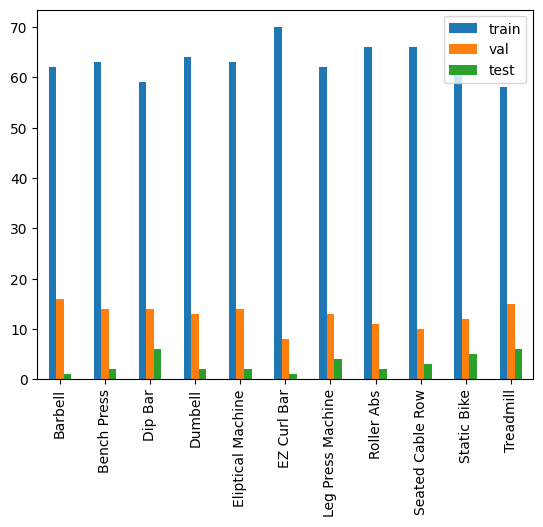

In [ ]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

In [ ]:
print(sum(val_counts))

140


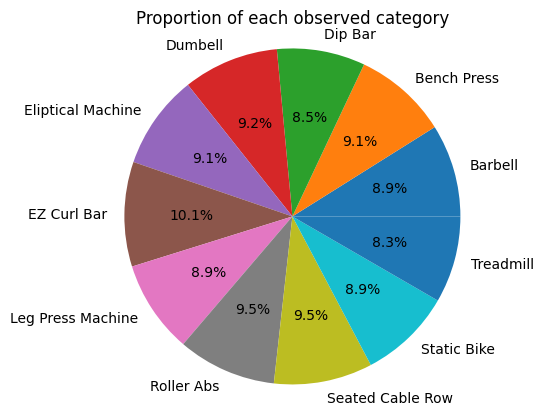

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
train_images

array([[[[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.]],

        [[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.]],

        [[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.]],

        ...,

        [[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.]],

        [[254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.],
         ...,
         [254., 254., 254.],
         [254., 254., 254.],
         [254., 254., 254.]],

        [[254., 254., 254.],
       

In [ ]:
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

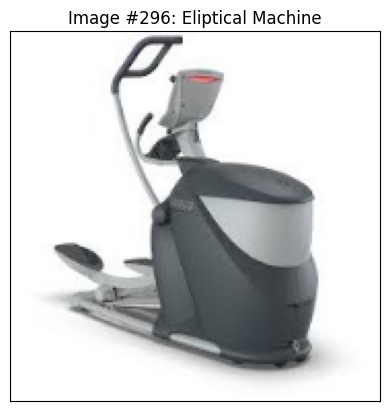

In [ ]:
def display_random_image (class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()

display_random_image (class_names, train_images, train_labels)

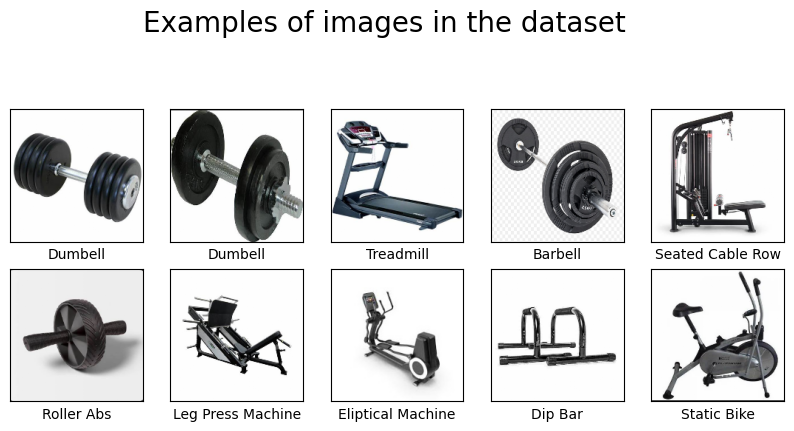

In [ ]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=20)
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

display_examples(class_names, train_images, train_labels)

In [ ]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(180, 180, 3), include_top=False, weights="imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
for layer in pre_trained_model.layers[:-2]:
  layer.trainable = False
  #print(layer.name)

for i, layer in enumerate(pre_trained_model.layers):
  print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: input_1, Trainable: False
Layer 1: block1_conv1, Trainable: False
Layer 2: block1_conv2, Trainable: False
Layer 3: block1_pool, Trainable: False
Layer 4: block2_conv1, Trainable: False
Layer 5: block2_conv2, Trainable: False
Layer 6: block2_pool, Trainable: False
Layer 7: block3_conv1, Trainable: False
Layer 8: block3_conv2, Trainable: False
Layer 9: block3_conv3, Trainable: False
Layer 10: block3_pool, Trainable: False
Layer 11: block4_conv1, Trainable: False
Layer 12: block4_conv2, Trainable: False
Layer 13: block4_conv3, Trainable: False
Layer 14: block4_pool, Trainable: False
Layer 15: block5_conv1, Trainable: False
Layer 16: block5_conv2, Trainable: False
Layer 17: block5_conv3, Trainable: True
Layer 18: block5_pool, Trainable: True


In [ ]:
last_layer = pre_trained_model.get_layer('block5_conv2')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(11, activation='softmax')(x)

In [ ]:
model = tf.keras.Model(pre_trained_model.input, x)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
checkpoint = ModelCheckpoint(filepath='models.h5', save_best_only=True, save_weights_only=False,)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=9, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2,
    verbose = 1,
    factor = 0.3,
    min_lr = 0.000001)

In [ ]:
history1 = model.fit(
    train_images,
    train_labels,
    batch_size = 32,
    epochs = 10,
    validation_data=(val_images, val_labels),
    callbacks=[learning_rate_reduction],
    validation_steps=2
    )

Epoch 1/10
22/22 [==============================] - 283s 13s/step - loss: 2.5443 - accuracy: 0.2892 - val_loss: 1.2624 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 2/10
22/22 [==============================] - 282s 13s/step - loss: 1.1326 - accuracy: 0.6000 - val_loss: 0.5653 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/10
22/22 [==============================] - 284s 13s/step - loss: 0.7220 - accuracy: 0.7626 - val_loss: 0.2325 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 4/10
22/22 [==============================] - 277s 13s/step - loss: 0.5331 - accuracy: 0.8331 - val_loss: 0.2035 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 5/10
22/22 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8849 
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
22/22 [==============================] - 280s 13s/step - loss: 0.3410 - accuracy: 0.8849 - val_loss: 0.1750 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/10
22/22 [==============================] - 277s 13s/step

In [ ]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(10)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc, label = 'Training Accuracy', color='blue')
    ax[0].plot(epochs , val_acc, label = 'Validation Accuracy', color='teal')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss, label = 'Training Loss', color='blue')
    ax[1].plot(epochs , val_loss, label = 'Validation Loss', color='teal')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    plt.show()

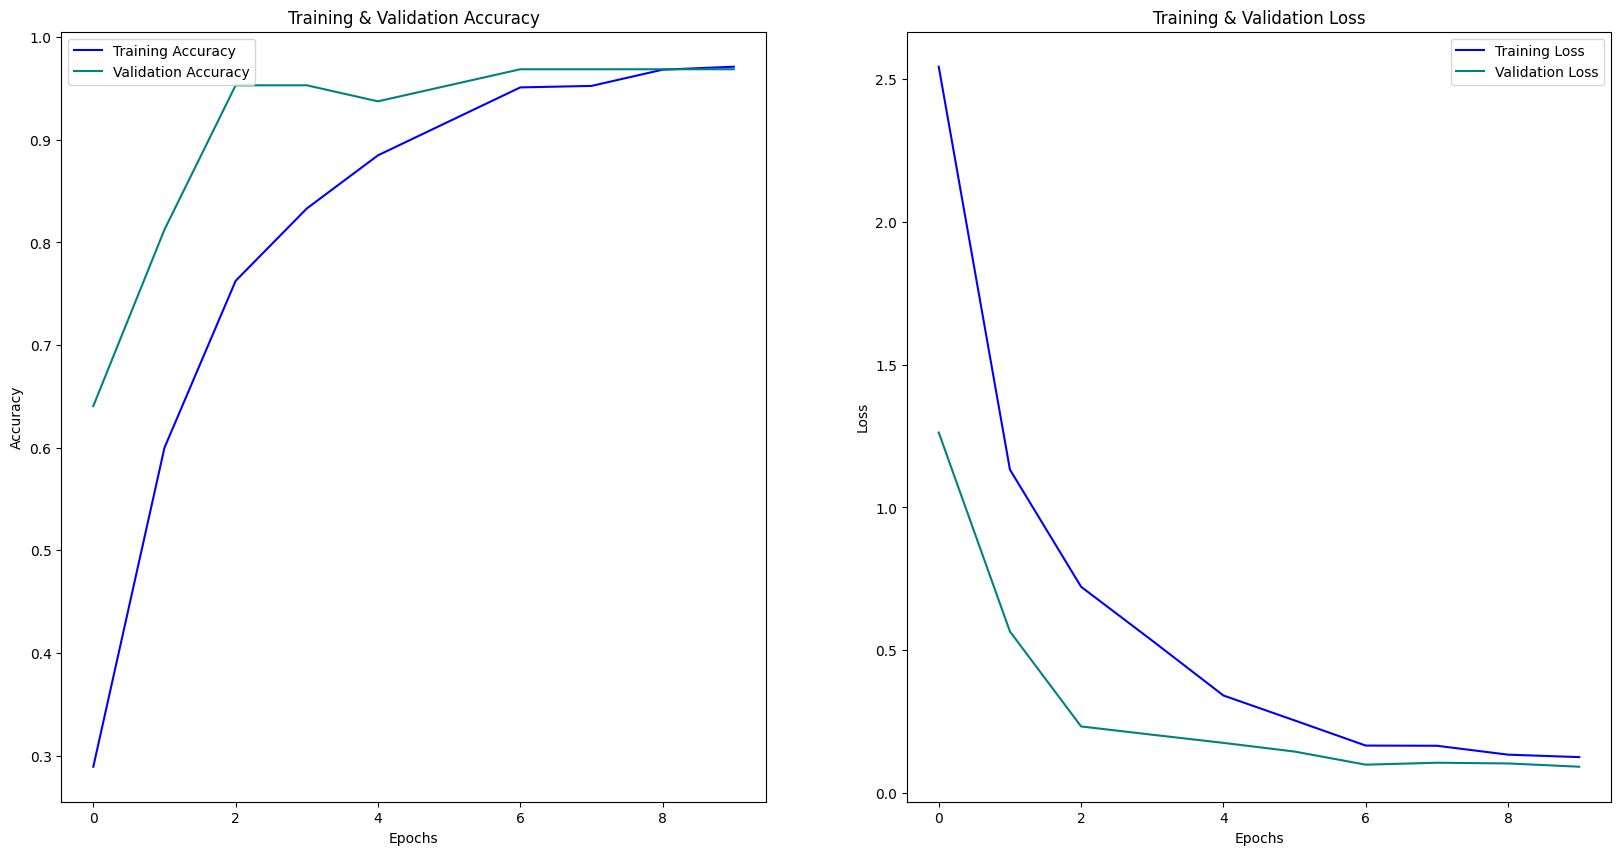

In [ ]:
plot_accuracy_loss_chart(history1)

In [ ]:
results = model.evaluate(test_images, test_labels)

print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

2/2 [==============================] - 12s 571ms/step - loss: 0.1400 - accuracy: 0.9706
Loss of the model is -  0.13996455073356628
Accuracy of the model is -  97.0588207244873 %


In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

2/2 [==============================] - 12s 553ms/step


array([ 2,  9, 10,  9,  2,  3,  2,  7,  2,  1,  4,  1,  9,  1,  7])

In [ ]:
print(classification_report(
    test_labels,
    predictions,
    target_names = ['Barbell','Bench Press','Dip Bar','Dumbell','Eliptical Machine', 'EZ Curl Bar', 'Leg Press Machine', 'Roller Abs', 'Seated Cable Row', 'Static Bike', 'Treadmill']))

In [ ]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], columns = [['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']])
cm

In [ ]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (4,4))
    sns.heatmap(
        cm,
        cmap = 'Reds',
        linecolor = 'black',
        linewidth = 1,
        annot = True,
        fmt = '',
        xticklabels = class_names,
        yticklabels = class_names)

plot_confusion_matrix(cm)

In [ ]:
from keras.models import load_model

# Misalkan model Anda disebut "model"
# Simpan model ke file H5
model.save('model.h5')

# Kemudian, jika Anda perlu memuat model dari file H5
loaded_model = load_model('model.h5')


In [ ]:
from keras.models import model_from_json

# Misalkan model Anda disebut "model"

# Simpan arsitektur model ke JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Simpan bobot model
model.save_weights("model.h5")


In [ ]:
import tensorflow as tf

# Misalkan model Anda disebut "model"
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
import pickle

# Misalkan model Anda disebut "model"
# Simpan model ke dalam file biner
with open('model.bin', 'wb') as f:
    pickle.dump(model, f)

# Baca kembali model dari file biner
with open('model.bin', 'rb') as f:
    loaded_model = pickle.load(f)

In [ ]:
pip install tensorflowjs


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 34.3 MB/s eta 0:00:00


In [ ]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'models')

Testing image

In [ ]:
/content/models

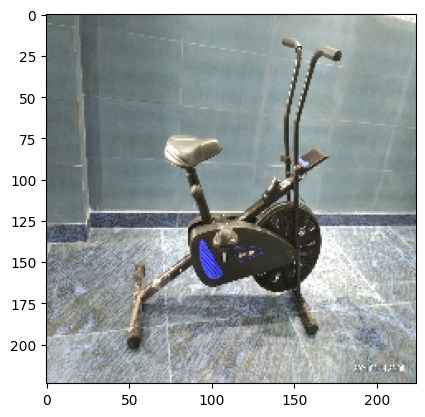

1/1 [==============================] - 0s 127ms/step
[9, 1, 2, 3, 4, 5, 6, 7, 8, 0, 10, 11]
Static Bike : 100.0 %
Bench Press : 0.0 %
Dip Bar : 0.0 %
Dumbell : 0.0 %
Eliptical Machine : 0.0 %
EZ Curl Bar : 0.0 %
Leg Press Machine : 0.0 %
Roller Abs : 0.0 %
Seated Cable Row : 0.0 %
Barbell : 0.0 %
Treadmill : 0.0 %


In [ ]:
import cv2
new_image = cv2.imread('staticbike.jpg')
resize_img = tf.image.resize(new_image, (224, 224))
plt.imshow(resize_img.numpy().astype(int))
plt.show()

prediction = model.predict(np.array([resize_img]))
list_index = [0,1,2,3,4,5,6,7,8,9,10,11]
x = prediction

for i in range(11):
    for j in range(11):
      if x[0][list_index[i]] > x[0][list_index[j]]:
        temp = list_index[i]
        list_index[i] = list_index[j]
        list_index[j] = temp
print(list_index)

for i in range(11):
    print(class_names[list_index[i]], ':', round(prediction[0][list_index[i]] * 100,2), '%')